# rgrg


In [1]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install git+https://github.com/Effective-Quadratures/Effective-Quadratures.git@feature_robust # for specific branch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from equadratures import *

#sns.set_style("darkgrid")

## Load Boston housing data-set 

In [2]:
boston = datasets.load_boston()
boston_df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])

## Add some random noise features

In [3]:
n_houses = boston_df.shape[0]
rand_noise = np.random.rand(n_houses, 5)

rand_noise_df = pd.DataFrame(data=rand_noise, columns=['Noise_1', 'Noise_2', 'Noise_3', 'Noise_4', 'Noise_5'])
Xorig = pd.concat([boston_df, rand_noise_df], axis=1)
y = boston['target']

## Scale data

In [4]:
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(Xorig)

## Create helper classes and functions

### EQmodel class to interface with sklearn

In [5]:
class EQmodel(object):
    def __init__(self,method,order=1,lamda=None,alpha=None,verbose=False):
        self.method = method
        self.order = order
        self.lamda = lamda
        self.alpha = alpha
        
    def fit(self,X,y):
        s = Parameter(distribution='uniform', lower=-1, upper=1, order=self.order,endpoints='both')
        self.param = [s for _ in range(X.shape[1])]
        self.basis = Basis('total-order') #Don't put tensor-grid, it will take forever!
        
        solver_args = {}
        if self.lamda is not None: solver_args["param1"] = self.lamda
        if self.alpha is not None: solver_args["param2"] =self.alpha
        self.poly = Poly(parameters=self.param, basis=self.basis, method=self.method, \
              sampling_args= {'mesh': 'user-defined', 'sample-points':X, 'sample-outputs': y.reshape(-1,1)},
               solver_args=solver_args)
        self.poly.set_model()
  
    def predict(self,X):
        return self.poly.get_polyfit(X)
        
    def score(self,X,y):
        ypred = self.poly.get_polyfit(X)
        r2 = r2_score(ypred,y)
        return r2
        
    # For sklearn gridsearch compatibility
    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {"method": self.method,"order": self.order, 
                "alpha": self.alpha, "lamda": self.lamda}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

### Gridsearch helper functions

In [6]:
def myGridSearch(model,parameters,X,y,kfold=5):
    cv = KFold(n_splits=kfold,shuffle=True,random_state=42)
    gs = GridSearchCV(model, parameters,return_train_score=True,cv=cv,verbose=2,n_jobs=-1)
    gs.fit(X, y)

    print("Best score = %.3f with parameters:" %gs.best_score_)
    print(gs.best_params_)
   
    # Parse full results into df
    results = pd.DataFrame(gs.cv_results_)
    results = results.loc[:,~results.columns.str.contains('_time|split|rank|params')] 
    return results

def plot_GS(results,ranges,params,x_axis,sub_axis,index,scale='log'):
    shape = [len(ranges[0]),len(ranges[1]),len(ranges[2])]
    mean_train_score = results['mean_train_score'].to_numpy().reshape(shape)
    mean_test_score = results['mean_test_score'].to_numpy().reshape(shape)

    # Rearrange scoring arrays. axis=0 will be xaxis of plots, take first indices of 
    # axis=1 for the two subplots, index axis=2 by "index"
    nplots = np.minimum(shape[sub_axis],2)
    remain_axis = list({0,1,2} - {x_axis,sub_axis})[0]
    reorder = [x_axis, sub_axis, remain_axis]
    plot_train = mean_train_score.transpose(reorder)[:,:nplots,index]
    plot_test  = mean_test_score.transpose(reorder)[:,:nplots,index]
    params = [params[i] for i in reorder]
    ranges = [ranges[i] for i in reorder]

    if nplots==1:
        fig, ax1 = plt.subplots(1, 1,figsize=(4,5),constrained_layout=True)
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(9,5),constrained_layout=True)
    fig.suptitle('$R^2$ vs %s, with %s = %.3f' %(params[0],params[2],ranges[2][0]))
    # subplot1
    ax1.set_title('%s = %.3f' %(params[1],ranges[1][0]))
    ax1.plot(ranges[0],plot_train[:,0],label='Train')
    ax1.plot(ranges[0],plot_test[:,0],label='Test')
    ax1.set_xscale(scale)
    ax1.set_xlabel(params[0])
    ax1.set_ylabel('$R^2$')
    ax1.set_ylim([0.5,1.05*np.max(plot_train[:,0])])
    ax1.legend()
    if nplots==2:
        # subplot2
        ax2.set_title('%s = %.3f' %(params[1],ranges[1][1]))
        ax2.plot(ranges[0],plot_train[:,1],label='Train')
        ax2.plot(ranges[0],plot_test[:,1],label='Test')
        ax2.set_xscale(scale)
        ax2.set_xlabel(params[0])
        ax2.set_ylabel('$R^2$')
        ax2.set_ylim([0.5,1.05*np.max(plot_train[:,1])])
        ax2.legend()

    plt.show()

## Ordinary least squares regression

In [7]:
params = {'order':[1,2,3]}
linear = EQmodel('least-squares')
results = myGridSearch(linear,params,X,y,kfold=5)
display(results)

cv = KFold(n_splits=5,shuffle=True,random_state=42)
print('mean_test_score for sklearn OLS (order=1) = %.4f'
      %np.mean(cross_val_score(LinearRegression(), X, y, cv=cv)))

model = make_pipeline(PolynomialFeatures(2), LinearRegression())
print('mean_test_score for sklearn OLS (order=2) = %.4f'
      %np.mean(cross_val_score(model, X, y, cv=cv)))

model = make_pipeline(PolynomialFeatures(3), LinearRegression())
print('mean_test_score for sklearn OLS (order=3) = %.4f'
      %np.mean(cross_val_score(model, X, y, cv=cv)))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    1.5s remaining:    1.3s


Best score = 0.746 with parameters:
{'order': 2}


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.8s finished


,param_order,mean_test_score,std_test_score,mean_train_score,std_train_score
0,1,0.615209,0.034227,0.657212,0.016666
1,2,0.746117,0.050948,0.949110,0.004124
2,3,0.579216,0.071375,1.000000,0.000000


mean_test_score for sklearn OLS (order=1) = 0.7154
mean_test_score for sklearn OLS (order=2) = 0.7283
mean_test_score for sklearn OLS (order=3) = 0.4720


## Elastic net regression

### Effective Quadratures

In [8]:
lamda_range = np.logspace(-5, 0, 20)
alpha_range = [0.5]
order_range = [1,2]
params = {'lamda':lamda_range,'alpha':alpha_range,'order':order_range}
elasticnet = EQmodel('elastic-net')
results_eq = myGridSearch(elasticnet,params,X,y,kfold=5)
#display(results_eq)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.0s finished


0.013183254493651791
0.013183254493651791
Best score = 0.818 with parameters:
{'alpha': 0.5, 'lamda': 0.026366508987303583, 'order': 2}


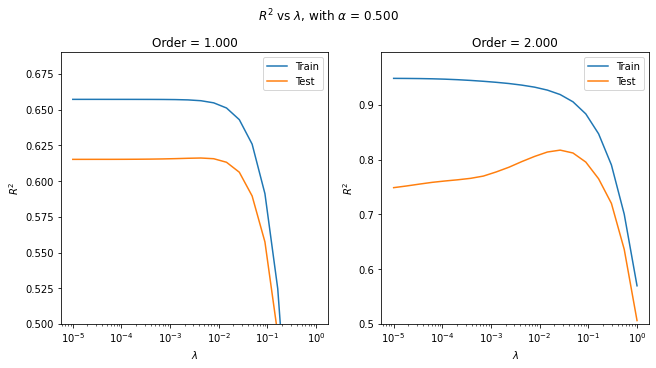

In [9]:
ranges = [lamda_range,alpha_range,order_range]
params = ['$\lambda$','$\\alpha$','Order']
plot_GS(results_eq,ranges,params,0,2,0,scale='log')

Best parameters are $\alpha=0.5$, $\lambda=0.0144$ and polynomial order = 2.

### Scikit-learn

In [10]:
params = {'alpha':lamda_range,'l1_ratio':alpha_range}
poly = PolynomialFeatures(2)
Xpoly = poly.fit_transform(X)
results_sk = myGridSearch(ElasticNet(),params,Xpoly,y,kfold=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


Best score = 0.841 with parameters:
{'alpha': 0.007847599703514606, 'l1_ratio': 0.5}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


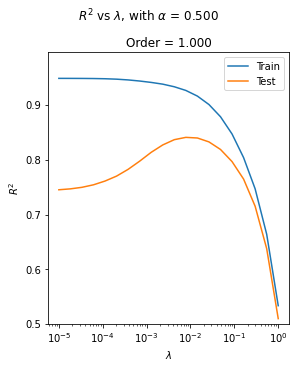

In [11]:
ranges = [lamda_range,alpha_range,[1]]
params = ['$\lambda$','$\\alpha$','Order']
plot_GS(results_sk,ranges,params,0,2,0,scale='log')

Best parameters are $\alpha=0.5$, $\lambda=0.0043$ and polynomial order = 2.

## What is the "correct" polynomial order

In [12]:
lamda_range = [1e-5,0.025]
alpha_range = [0.5]
order_range = [1,2,3,4]
params = {'lamda':lamda_range,'alpha':alpha_range,'order':order_range}
elasticnet = EQmodel('elastic-net')
results_eq = myGridSearch(elasticnet,params,X,y,kfold=5)

In [13]:
ranges = [lamda_range,alpha_range,order_range]
params = ['$\lambda$','$\\alpha$','Order']
plot_GS(results_eq,ranges,params,2,0,0,scale='linear')

## Looking at the coefficients

Just do this for 1st order to keep simple, but could extend to look at higher order terms too...

In [128]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42,shuffle=True)

Training R2 = 0.650
Test R2 = 0.657
Training MAE = 3.3
Test MAE = 3.0


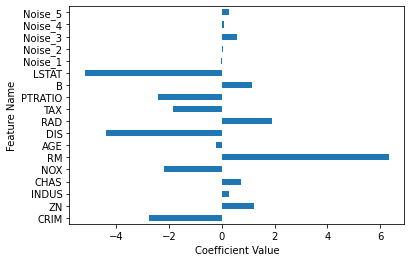

In [129]:
ltsq = EQmodel('least-squares',order=1)
ltsq.fit(X,y)
print('Training R2 = %.3f' %(ltsq.score(X_train,y_train)))
print('Test R2 = %.3f'     %(ltsq.score(X_test,y_test)))

ypred = ltsq.predict(X_train)
MAE = mean_absolute_error(ypred,y_train)
print('Training MAE = %.1f' %MAE)
ypred = ltsq.predict(X_test)
MAE = mean_absolute_error(ypred,y_test)
print('Test MAE = %.1f' %MAE)

coeffs = ltsq.poly.get_coefficients().squeeze()
pd.Series(coeffs[:0:-1], 
              index=Xorig.columns).plot(kind='barh')
#plt.title(model[1])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.show()

0.14
0.0
Training R2 = 0.602
MAE = 3.2


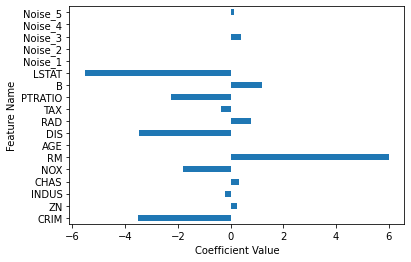

In [163]:
elasticnet = EQmodel('elastic-net',order=1,lamda=0.14,alpha=1)
elasticnet.fit(X,y)
print('Training R2 = %.3f' %(elasticnet.score(X,y)))

ypred = elasticnet.predict(X)
MAE = mean_absolute_error(ypred,y)
print('MAE = %.1f' %MAE)


coeffs = elasticnet.poly.get_coefficients().squeeze()
pd.Series(coeffs[:0:-1], 
             index=Xorig.columns).plot(kind='barh')
#plt.title(model[1])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.show()

0.2
0.0


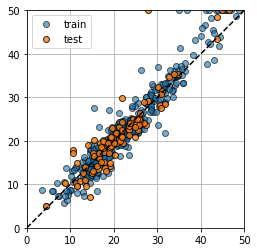

0.8935094681276823
0.791753090338658


In [174]:
elasticnet = EQmodel('elastic-net',order=3,lamda=0.2,alpha=1)
elasticnet.fit(X_train,y_train)
fig, ax = plt.subplots()
ypred = elasticnet.predict(X_train)
ax.plot(ypred,y_train,'o',alpha=0.6,mec='k',label='train')
ypred = elasticnet.predict(X_test)
ax.plot(ypred,y_test,'o',alpha=0.8,mec='k',label='test')
ax.plot([0,50],[0,50],'k--')
ax.set_aspect(1)
ax.set_xlim([0,50])
ax.set_ylim([0,50])
ax.grid('on')
plt.legend()
plt.show()

print(elasticnet.score(X_train,y_train))
print(elasticnet.score(X_test,y_test))

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train,y_train)
fig, ax = plt.subplots()

ypred = rf.predict(X_train)
ax.plot(ypred,y_train,'o',alpha=0.6,mec='k',label='train')
ypred = rf.predict(X_test)
ax.plot(ypred,y_test,'o',alpha=0.8,mec='k',label='test')
ax.plot([0,50],[0,50],'k--')
ax.set_aspect(1)
ax.set_xlim([0,50])
ax.set_ylim([0,50])
ax.grid('on')
plt.legend()
plt.show()

print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

In [ ]:
# TODO - add poly variance!